In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import csv
%matplotlib inline


def calc_ex(filename):
    
    x = []
    y = []
    z = []

    with open(filename) as f:
        reader = csv.reader(f)
        for row in [row for row in reader]:
            #print(row[0], row[1], row[2])
            #print(row[1])
            x.append(row[0])
            y.append(int(row[1]))
            z.append(int(row[2]))
    x = [int(r) for r in x[1:]]
    x.insert(0, 0)

    num_cols = np.count_nonzero(np.array(y) == 0)
    num_rows = np.count_nonzero(np.array(x) == 0)
    X = np.array(x).reshape((num_cols, num_rows)).T
    Y = np.array(y).reshape((num_cols, num_rows)).T
    Z = np.array(z).reshape((num_cols, num_rows)).T
    dx_array = np.zeros((num_rows, num_cols-1))
    pxx_array = np.zeros((num_rows, num_cols-1))
    pxy_array = np.zeros((num_rows, num_cols-1))
    dy_array = np.zeros((num_rows-1, num_cols))
    pyx_array = np.zeros((num_rows-1, num_cols))
    pyy_array = np.zeros((num_rows-1, num_cols))

    for i in range(num_rows - 1):
        dy_array[i][0] = (Z[i+1][0] - Z[i][0]) / (Y[i+1][0] - Y[i][0])
        pyy_array[i][0] = (Y[i+1][0] + Y[i][0]) / 2
        pyx_array[i][0] = X[i][0]

        for j in range(num_cols - 1):
            dx_array[i][j] = (Z[i][j+1] - Z[i][j]) / (X[i][j+1] - X[i][j])
            pxx_array[i][j] = (X[i][j+1] + X[i][j]) / 2
            pxy_array[i][j] = Y[i][j+1]

            dy_array[i][j+1] = (Z[i+1][j+1] - Z[i][j+1]) / (Y[i+1][j+1] - Y[i][j+1])
            pyy_array[i][j+1] = (Y[i+1][j+1] + Y[i][j+1]) / 2
            pyx_array[i][j+1] = X[i][j+1]

            dx_array[num_rows - 1][j] = (Z[num_rows - 1][j+1] - Z[num_rows - 1][j]) / (X[num_rows - 1][j+1] - X[num_rows - 1][j])
            pxx_array[num_rows - 1][j] = (X[num_rows - 1][j+1] + X[num_rows - 1][j]) / 2
            pxy_array[num_rows - 1][j] = Y[num_rows - 1][0]

    pdxx, pdxy = pxx_array.reshape(-1), pxy_array.reshape(-1)
    pdyx, pdyy = pyx_array.reshape(-1), pyy_array.reshape(-1)
    pdx = dx_array.reshape(-1)
    pdy = dy_array.reshape(-1)

    dx_array_rescale = dx_array[1: num_rows-1, :]
    dy_array_rescale = dy_array[:, 1:num_cols-1]

    evx_array = np.zeros((num_rows-2, num_cols-2))
    evy_array = np.zeros((num_rows-2, num_cols-2))

    for i in range(num_rows - 2):
        for j in range(num_cols - 2):
            evx_array[i][j] = (dx_array_rescale[i][j+1] * dx_array_rescale[i][j]) < 0
            evy_array[i][j] = (dy_array_rescale[i+1][j] * dy_array_rescale[i][j]) < 0
    ev_array = np.pad(evy_array*evx_array, (1, 1), "constant").T
    #ev = ev_array.reshape(len(z))
    
    with open('result/dx_' + filename, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["X", "Y", "dx"])

        for i in range(len(pdx)):
            writer.writerow([pdxx[i], pdxy[i], int(pdx[i])])
            
    with open('result/dy_' + filename, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["X", "Y", "dy"])

        for i in range(len(pdy)):
            writer.writerow([pdyx[i], pdyy[i], int(pdy[i])])
    
    return X, Y, Z, dx_array, dy_array, ev_array
    

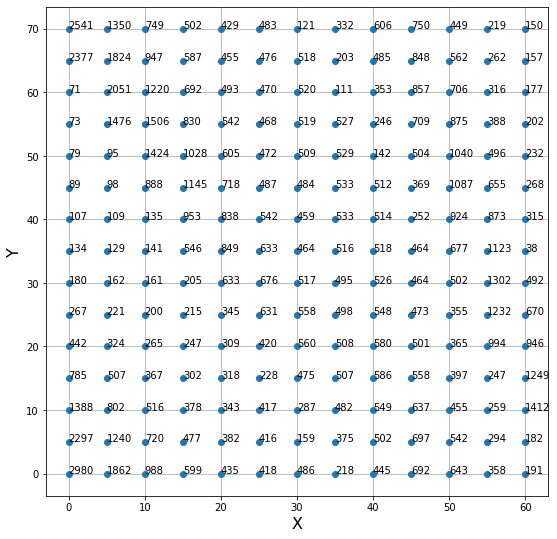

In [2]:
ex_source_file = "example2.csv"
df_source_file = "test.csv"

X, Y, Z, _, _, _ = calc_ex(ex_source_file)
_, _, _, dx_array, dy_array, ev_array = calc_ex(df_source_file)

predicted_map = np.zeros((Z.shape[0], Z.shape[1]))

ev_index = np.where(ev_array)
for idx in zip(ev_index[0], ev_index[1]):
    
    this_predicted_map = np.zeros((Z.shape[0], Z.shape[1]))
    rootX, rootY = idx[0], idx[1]
    root_ex = Z[rootY][rootX]
    this_predicted_map[rootY][rootX] += root_ex

    for i in range(1, rootX + 1):
        ch = this_predicted_map[rootY][(rootX - i) + 1] - dx_array[rootY][(rootX - i)] * (X[rootY][(rootX - i) + 1] - X[rootY][(rootX - i)])
        this_predicted_map[rootY][rootX - i] += ch
        
    for i in range(1, (Z.shape[1] - rootX)):
        ch = this_predicted_map[rootY][(rootX + i) - 1] + dx_array[rootY][(rootX + i) - 1] * (X[rootY][(rootX + i)] - X[rootY][(rootX + i) - 1])
        this_predicted_map[rootY][rootX + i] += ch
        
    for i in range(1, rootY + 1):
        for j in range(Z.shape[1]):
            ch = this_predicted_map[(rootY - i) + 1][j] - dy_array[(rootY - i)][j] * (Y[(rootY - i) + 1][j] - Y[(rootY - i)][j])
            this_predicted_map[rootY - i][j] += ch

    for i in range(1, (Z.shape[0] - rootY)):
        for j in range(Z.shape[1]):
            ch = this_predicted_map[(rootY + i) - 1][j] + dy_array[(rootY + i) - 1][j] * (Y[(rootY + i)][j] - Y[(rootY + i) - 1][j])
            this_predicted_map[rootY + i][j] += ch
    
    predicted_map += this_predicted_map

predicted_map = predicted_map // 4

x = X.T.reshape(-1)
y = Y.T.reshape(-1)
z = predicted_map.reshape(-1)

plt.figure(figsize=(9, 9))
plt.xlabel("X", fontsize=16)
plt.ylabel("Y", fontsize=16)
plt.grid()
plt.plot(x, y, marker='o', linestyle='')
for i in range(len(z)):
    plt.text(x[i], y[i], str(int(z[i])))

with open('result/predicted_map.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["X", "Y", "Z"])
    
    for i in range(len(z)):
        writer.writerow([x[i], y[i], int(z[i])])